In [2]:
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
from scipy import signal
import numpy as np
import scipy
from scipy import signal
from scipy.ndimage.morphology import binary_dilation as bd
import scipy.ndimage as ndimage
from functools import partial
import multiprocessing
import numpy.ma as ma
from collections import Counter
import cPickle as pkl
import pylab as plt
%matplotlib inline

In [3]:
inds = pkl.load(open('pkls/gaus_trans.pkl','rb'))
data = parallel_rw_pkl(None, 'test_patch', 'r')
mask = parallel_rw_pkl(None, 'mtest_patch', 'r')
modis_sent = ma.array(data, mask=mask)

Sent = parallel_rw_pkl(None, 'b4test_patch', 'r')
stm = parallel_rw_pkl(None, 'stmtest_patch', 'r')
p_mask = np.unique(stm)

struct = ndimage.generate_binary_structure(2, 2)

In [3]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5

    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
    xgaus = []
    for k in np.arange(winx):
        f = np.exp(-0.5*(k*np.pi*xstd/winx)**2)
        xgaus.append(f)

    ygaus = []
    for k in np.arange(winy):
        f = np.exp(-0.5*(k*np.pi*xstd/winy)**2)
        ygaus.append(f)

    gaus  = np.outer(xgaus, ygaus)
    
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    #center = np.array(r_gaus.shape)/2
    #cgaus = r_gaus[center[0]-xwin/2.: center[0]+xwin/2., center[1]-ywin/2.:center[1]+ywin/2.]
    #if norm:
     #   return cgaus/cgaus.sum()
    #else:
    return r_gaus

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


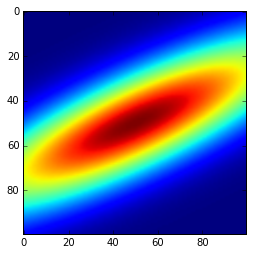

In [64]:
#xwin = 100; ywin = 100; xstd = 1; ystd=1
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2.: center[0]+xwin/2., center[1]-ywin/2.:center[1]+ywin/2.]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus


plt.imshow(gaussian(100,100, 10,40,25))

In [72]:
gaus = gaussian(100, 100, 10, 20, 90, norm = True)
#gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                            
kernel = np.zeros((99, 225))
kernel[inds[1], inds[0]] = gaus.ravel()

if kernel.sum() <= 0:
    print 'invalid gauss: %s'%([xstd, ystd, angle])
    pass
else:
    ker = kernel/(kernel.sum())

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


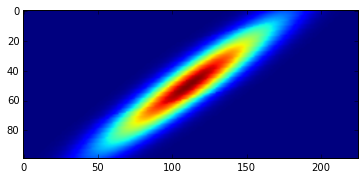

In [73]:
plt.imshow(ker)

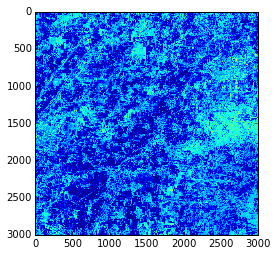

In [74]:
plt.imshow(Sent)

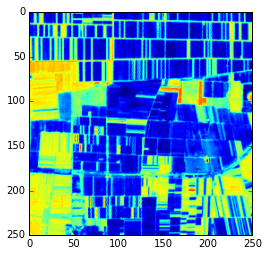

In [75]:
plt.imshow(Sent[0:250,0:250])

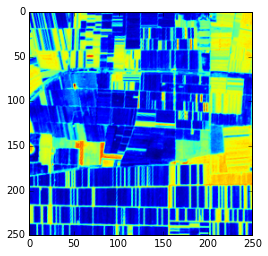

In [76]:
plt.imshow(Sent[0:250,0:250][::-1,::-1])

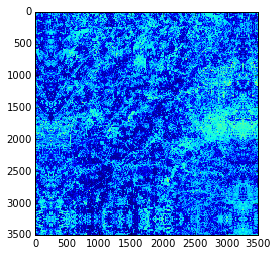

In [77]:
a = np.zeros(np.array(Sent.shape)+500)
a[0:250,0:250] = Sent[0:250,0:250][::-1,::-1]
a[0:250,250:3250] = Sent[0:250,::][::, ::-1]
a[250:3250, 0:250] = Sent[::,0:250][::,::-1]
a[3250:, 0:250] = Sent[-250:,0:250][::-1,::-1]
a[3250:,250:3250] = Sent[-250:, ::][::-1,::]
a[3250:,3250:] = Sent[-250:, -250:][::-1,::-1]
a[250:3250, 3250:] = Sent[::, -250:][::,::-1]
a[0:250,3250:] = Sent[:250,-250:][::-1,::-1]
a[250:3250, 250:3250] = Sent
plt.imshow(a)

In [78]:
conved = signal.fftconvolve(a, ker, mode='valid')

In [79]:
conved[250:3250,250:3250].shape

(3000, 3000)

<matplotlib.colorbar.Colorbar instance at 0x7f051b187128>

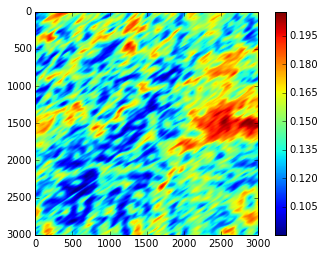

In [80]:
plt.imshow(conved[250:3250,250:3250])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f051b0316c8>

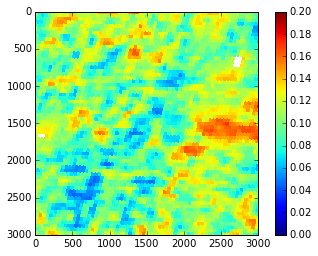

In [81]:
plt.imshow(modis_sent*0.001, vmin=0, vmax=0.20)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f051af143b0>

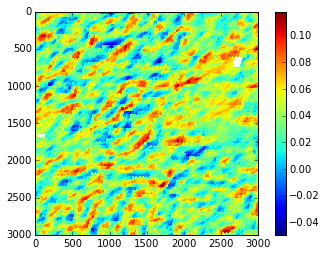

In [82]:
plt.imshow(conved[250:3250,250:3250] - modis_sent*0.001)
plt.colorbar()

In [151]:
m = modis_sent*0.001
s = conved[250:3250,250:3250]
np.nansum((s-s.mean())*(m-m.mean()))

2012.1926279466438

In [84]:
#correlation_coefficient
m = modis_sent*0.001
cc_u = np.nansum((s-s.mean())*(m-m.mean()))
cc_d = np.sqrt(np.nansum((s-s.mean())**2))*np.sqrt(np.nansum(((m-m.mean())**2)))
cc = cc_u/cc_d 
cc

0.45358733789645045

In [85]:
from scipy.stats import linregress

Only the pixels that in the middle of interpolated modis to Sentinel pixels should be considered as valid values, and the linear relationship between them should be considered rather than the whole images.

In [111]:
c_pixels = []
for i in np.unique(stm):
    mask = (stm==i)  
    #brdf = (Counter(modis_sent[mask]).most_common(1)[0][0])*0.001
    xmin = np.where(mask)[0].min()
    xmax = np.where(mask)[0].max()
    ymin = np.where(mask)[1].min()
    ymax = np.where(mask)[1].max()

    indx = np.where(mask)[0]
    indy = np.where(mask)[1]

    center = np.array([(xmax+xmin)/2, (ymax+ymin)/2])
    c_pixels.append(center)

In [112]:
parallel_rw_pkl(c_pixels, 'c_pixels', 'w')

Length of data: 4265
Length of data: 35


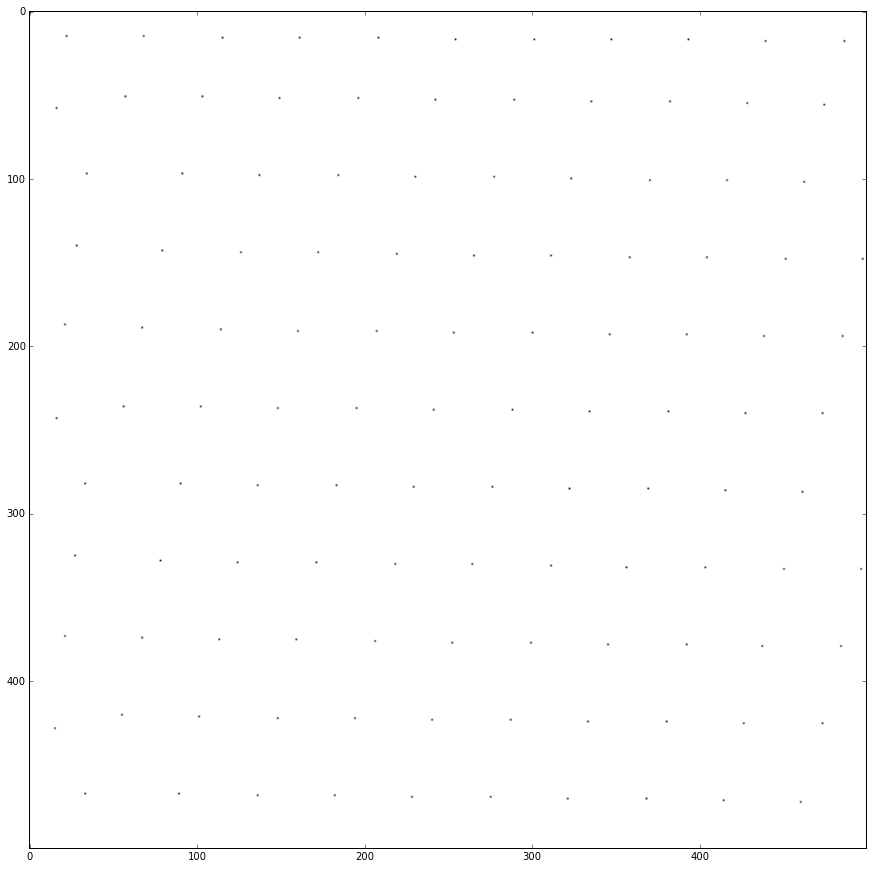

In [133]:
plt.figure(figsize=(15,15))
c_pixels = np.array(c_pixels).T
a = np.zeros((3000,3000))
a[:] = np.nan
a[c_pixels[0], c_pixels[1]] = 1
plt.imshow(a[:500, :500])

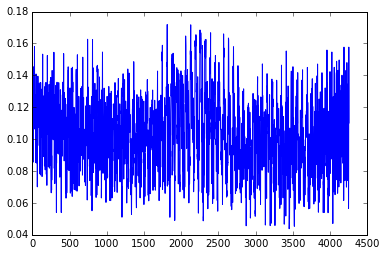

In [146]:
plt.plot(vm[~vm.mask])

In [154]:
vm = m[c_pixels[0], c_pixels[1]]
vs = s[c_pixels[0], c_pixels[1]]

LinregressResult(slope=0.4917285577921135, intercept=0.033409388320830735, rvalue=0.44794942022883405, pvalue=3.1529496034818181e-209, stderr=0.015045713961071402)


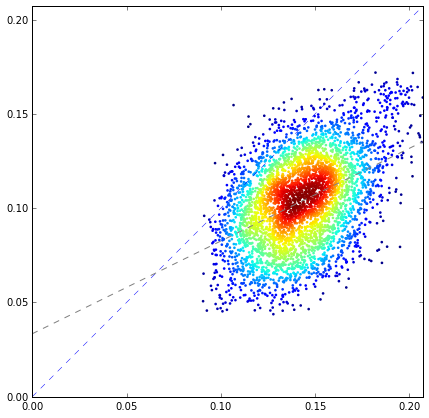

In [158]:
from scipy.stats import gaussian_kde
# x is brdf, y is the Sentinel
x,y = vm[~vm.mask], vs[~vm.mask]

xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

maxval = max(max(x), max(y))

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

Define a cost function that can be solved faster.

In [12]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2.: center[0]+xwin/2., center[1]-ywin/2.:center[1]+ywin/2.]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus


def conv(p, Sent, modis_sent, inds,c_pixels):
    
    xstd,ystd,angle, sx, sy = p
    print p
    
    xwin,ywin = 100,100
    gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                            

    kernel = np.zeros((99, 225))
    kernel[inds[1], inds[0]] = gaus.ravel()

    if kernel.sum() <= 0:
        print 'invalid gauss: %s'%([xstd, ystd, angle])
        pass
    else:
        ker = kernel/(kernel.sum())
    
    shape = 3000
    dia = 1000
    hdia = dia/2
    # for symetric dialation of the patche to avoid the border effects
    to_conv = np.zeros(np.array(Sent.shape)+dia)
    to_conv[:hdia,:hdia] = Sent[:hdia,:hdia][::-1,::-1]
    to_conv[:hdia,hdia:shape+hdia] = Sent[:hdia,::][::, ::-1]
    to_conv[hdia:shape+hdia, :hdia] = Sent[::,:hdia][::,::-1]
    to_conv[shape+hdia:, :hdia] = Sent[-hdia:,:hdia][::-1,::-1]
    to_conv[shape+hdia:,hdia:shape+hdia] = Sent[-hdia:, ::][::-1,::]
    to_conv[shape+hdia:,shape+hdia:] = Sent[-hdia:, -hdia:][::-1,::-1]
    to_conv[hdia:shape+hdia, shape+hdia:] = Sent[::, -hdia:][::,::-1]
    to_conv[:hdia,shape+hdia:] = Sent[:hdia,-hdia:][::-1,::-1]
    to_conv[hdia:shape+hdia, hdia:shape+hdia] = Sent
    
    shx = hdia+sx; shy = hdia + sy

    s = signal.fftconvolve(to_conv, ker, mode='valid')[shx:shape+shx,shy:shape+shy]
    m = modis_sent*0.001
        
    vm = m[c_pixels[0], c_pixels[1]]
    vs = s[c_pixels[0], c_pixels[1]]
    vm = vm[~vm.mask]; vs = vs[~vm.mask]    
    r = scipy.stats.linregress(vs,vm)
    cost = 1-r.rvalue
    print cost
    return cost

In [ ]:
from scipy import optimize
c_pixels = np.array(parallel_rw_pkl(None, 'c_pixels', 'r')).T
p = np.array([9.,32., 91., 3, -7])
bound = np.array([(8.,40.),(10.,80.),(30.,170.),(-50.,50.),(-50.,50.)])
psolve =  resbrute = optimize.brute(conv, bound, args=[Sent, modis_sent, inds,c_pixels], 
                                    full_output=True,finish=optimize.fmin)